This notebook is intended as a test of the Heron Gaussian Process regressor using the George Gaussian process package as its back-end. In order to keep memory constraints nice for optimisation we limit the training of the Gaussian Process (GP) to 20 waveforms.

The ultimate goal of this project is to use a GP to provide a surrogate model for BBH waveforms produced using Numerical Relativity (NR) codes. The NR waveforms we will test the method on are extracted from the Georgia Tech (GT) waveform catalogue, however, in order to allow rapid testing, the training data used in this notebook are produced using IMRPhenomP, a Post-Newtonian (PN) approximant. This allows the production of test data to validate the GP model.

In order to select training waveforms we selected the subset of all GT waveforms which are non-spinning, of which there are 44 unique waveforms. This leaves the only free parameter in the model as the mass ratio, $q$, and so we are able to produce the model as a two-dimensional input GP model. These waveforms sample the $q$ parameter space unevenly between $q \in (0.07, 1.0)$.

In [1]:
import george
from heron import data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy

The waveforms are produced by the IMRPhenomP function from `LALSimulation`. Below is a function to make the production of these waveforms simpler than the standard Python interface to the function.

In [2]:
import lalsimulation, lal

def generate_new_points(massratio, spin1x, npoints = 300, tstart = -0.1, tend = 0.005):
    """
    
    Parameters
    ----------
    massratio : float
        The ratio of the two component masses.
    spin1x : array
        The vector of spin components for mass 1.
    spin2x : array
        The vector of spin components for mass 2.
    npoints : int
        The desired number of points in the output waveform
    tstart : float
        The start time of the output waveform.
    tend : float
        the end time of the output waveform.
    
    Outputs
    -------
    data : array
        An array of data in the format expected by the heron data object.
    
    """
    chi1_l = 0
    chi2_l = 0
    chip = 0
    thetaJ = 0
    mass2 = 15 * lal.MSUN_SI
    mass1 = mass2 / massratio
    print mass1 / lal.MSUN_SI
    distance = 5 * lal.PC_SI
    alpha0 = 0
    phic = 0
    f_ref = 100 * lal.HertzUnit,
    waveflags = lalsimulation.SimInspiralCreateWaveformFlags()
    approximant = lalsimulation.SimInspiralGetApproximantFromString("IMRPhenomP")
    #phorder = lalsimulation.SimInspiralGetOrderFromString("IMRPhenomP0")
    #f, ax = plt.subplots(10, sharey=True, figsize=(5,15))
    data = np.zeros((npoints, 4))
    #m1 = mass1 / lal.MSUN_SI
    coaphase = 0
    
    spin1x, spin1y, spin1z = spin1x,0,0
    spin2x, spin2y, spin2z = 1,0,0
    flower = 10 
    fref = 10
    distance = 400 *1e6 * lal.PC_SI
    z = 0.0
    inclination = 0.0
    lambda1 = lambda2 = 0.0
    amporder = 0
    phorder = 0
    dt = (tend-tstart)/npoints
    hp, hc = lalsimulation.SimInspiralTD(coaphase, dt, 
                                         mass1, mass2,
                                         spin1x, spin1y, spin1z,
                                         spin2x, spin2y, spin2z,
                                         flower, fref, distance, z,
                                         inclination, lambda1, lambda2,
                                         waveflags, None, amporder, phorder,
                                         approximant
                                        )
    times = np.linspace(0, len(hp.data.data)*hp.deltaT, len(hp.data.data)) + hp.epoch
    data[:,-1] =  hp.data.data[(tstart<times) & (times<tend)]
    data[:,0] = times[(tstart<times) & (times<tend)]
    data[:,1] = massratio * np.ones(npoints)
    data[:,2] = spin1x * np.ones(npoints)
    return data

A quick test on a single waveform. (i.e. a one-dimensional-input GP).

In [3]:
bbh_data = generate_new_points(0.5, 0, 100, tstart=-0.01) #np.vstack([generate_new_points(5, 0), generate_new_points(6, 0)])
bbh_test = generate_new_points(0.5, 0, npoints = 1000)
bbh = data.Data(np.atleast_2d(bbh_data[:,:1]), np.atleast_2d(bbh_data[:,-1]),  
                    target_names = ["Times"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    test_targets = bbh_test[:,:1],
                    test_labels = bbh_test[:,-1]
                    )

30.0
30.0


In [4]:
from george import kernels
from heron import regression
kernel = 1 * kernels.ExpSquaredKernel(0.00015)

In [5]:
gp = regression.Regressor(bbh, kernel=kernel, yerror = 1e-23, tikh=1e-6)

In [6]:
gp.optimise()

      fun: 34.827569947862855
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ -1.71758425e+01,   1.67575206e-09,   4.43495976e+01,
        -9.74988100e+01])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 0
     njev: 33
   status: 2
  success: False
        x: array([  0.        , -27.40787756,   0.        ,  -8.80487526])

In [7]:
t = np.linspace(-0.01,0.005, 1000)
new_point = np.zeros((1000,1))
#new_point[:,1] = 6
#new_point[:,2] = 0
new_point[:,0] = t

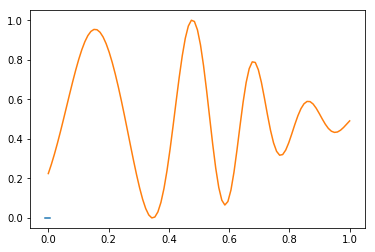

In [8]:
t = np.linspace(-0.01,0.005, 1000)
new_point = np.zeros((1000,1))
#new_point[:,1] = 6
#new_point[:,2] = 0
new_point[:,0] = t
#kernel = 0.2 * kernels.ExpSquaredKernel(0.0001, axes=[0])
gp = regression.Regressor(bbh, kernel=kernel, yerror = 1e-23, tikh=1e-6)
gp.optimise()
plt.plot(new_point[:,0], gp.prediction(new_point)[0])
#plt.ylim([-1.5e-22, 1.5e-22]);
#plt.plot(gp.training_data[:,0], gp.training_y)
plt.plot(gp.training_data[:,0], gp.training_y)

In [9]:
gp.test_predict()

In [10]:
gp.correlation()

1.004010020035057

In [11]:
# # Georgia Tech Mass ratios
ratios = [ 0.06649688,  0.07314657,  0.07979625,  0.0831211 ,  0.08644594,
        0.09309563,  0.09974532,  0.106395  ,  0.11304469,  0.11636954,
        0.11969438,  0.12634407,  0.13299376,  0.13964344,  0.14629313,
        0.14961798,  0.15294282,  0.15959251,  0.16624219,  0.17289188,
        0.17954157,  0.18619126,  0.19284095,  0.19949063,  0.20614099,
        0.21279001,  0.2194397 ,  0.22608872,  0.23273907,  0.23938943,
        0.24603845,  0.2526888 ,  0.25933716,  0.26598751,  0.27263786,
        0.27928622,  0.28593724,  0.29258693,  0.29923662,  0.33248372,
        0.39898193,  0.46547815,  0.66472407,  1.        ]

In [12]:
test_ratios = ratios[:-1] + np.diff(ratios)/2

In [13]:
ratios[20]

0.17954157

In [14]:
bbh_data_2 = np.vstack([generate_new_points(ratio, 0, 250, tstart=-0.10, tend=0.05) for ratio in ratios[:20]])
bbh_test_2 = np.vstack([generate_new_points(ratio, 0, 250, tstart=-0.10, tend=0.05) for ratio in test_ratios[:20]])
                        #generate_new_points(7, 0, 250, tstart=-0.005), 
                        #generate_new_points(9, 0, 250, tstart=-0.005), 
                        #generate_new_points(15, 0, 250,tstart=-0.005)])

#bbh_test_2 = np.vstack([generate_new_points(7, 0, 1000, tstart=-0.005)])#, generate_new_points(10, 0, 1000), generate_new_points(15, 0, 1000)])

225.574493119
205.06771541
187.9787584
180.459594495
173.51884889
161.124641404
150.382995413
140.9840688
132.690885348
128.899710354
125.319167032
118.72341931
112.78724656
107.416431449
102.533864714
100.255330275
98.0758691385
93.9893733108
90.2298026752
86.7594244449
214.832847513
196.151738277
184.142450144
176.921175247
167.092222709
155.568617558
145.531936692
136.711822734
130.767825518
127.084223629
121.932161416
115.679228133
110.036341336
104.91837403
101.381796716
99.1536246599
95.9891478509
92.0712250721
88.4605902321
85.122453615


In [15]:
bbh_2 = data.Data(bbh_data_2[:,:2], bbh_data_2[:,-1],
    #bbh_text[:,:2], bbh_text[:,-1],              
                    target_names = ["Times", "Mass"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    test_targets = bbh_test_2[:,:2],
                    test_labels = bbh_test_2[:,-1]
                    )

In [16]:
#(bbh_2.targets[5,0] - bbh_2.targets[4,0])**2
#k1 = np.std(bbh_2.labels) *  kernels.ExpSquaredKernel(0.0009 , axes = 0, ndim=2)
#k2 =  kernels.ExpSquaredKernel((0.0125)**2, axes = 1, ndim=2)
#k2 =  kernels.ExpSquaredKernel(1**2, axes = 1, ndim=2)

k1 = np.std(bbh_2.labels) *  kernels.ExpSquaredKernel(0.00015, axes = 0, ndim=2)
k2 =  kernels.ExpSquaredKernel((1./39.9)**2, axes = 1, ndim=2)
kernel =  k1 * k2
gp = regression.Regressor(bbh_2, kernel=kernel, yerror = 1e-23, tikh=1e-6)
#gp.gp.set_vector(np.log([  0.039,   0.005**2,   0.4**2]))
#gp.optimise()

In [17]:
gp.optimise()

      fun: -23298.737465560458
 hess_inv: array([[  2.83776402e-05,  -4.51575109e-05,   9.45380720e-06,
          3.45032963e-07,   1.74600214e-05],
       [ -4.51575109e-05,   1.99526377e-03,  -3.85540699e-05,
          2.36006661e-07,  -1.24264783e-04],
       [  9.45380720e-06,  -3.85540699e-05,   1.08691295e-04,
          5.53407178e-06,   8.30015477e-05],
       [  3.45032963e-07,   2.36006660e-07,   5.53407178e-06,
          2.93897497e-07,   3.38794355e-06],
       [  1.74600214e-05,  -1.24264783e-04,   8.30015477e-05,
          3.38794355e-06,   1.29935388e-04]])
      jac: array([  2735.47352379,     20.36257048,   1708.71518345, -17160.20241276,
         -873.36004094])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 37
      nit: 7
     njev: 26
   status: 2
  success: False
        x: array([  0.7882894 , -29.38452894,  -3.50930603,  -8.87705998,  -7.60837551])

In [21]:
gp.kernel.get_parameter_names()

['k1:k1:ln_constant', 'k1:k2:ln_M_0_0', 'k2:ln_M_0_0']

In [22]:
np.sqrt(1/np.exp(gp.kernel.get_vector()))

array([  5.78148282,  84.65044701,  44.8888893 ])

In [20]:
np.exp([  0.77680093, -27.3650829 ,  -3.26464779,  -8.86377583,  -7.12840452])

array([  2.17450473e+00,   1.30465445e-12,   3.82103908e-02,
         1.41420077e-04,   8.01997939e-04])

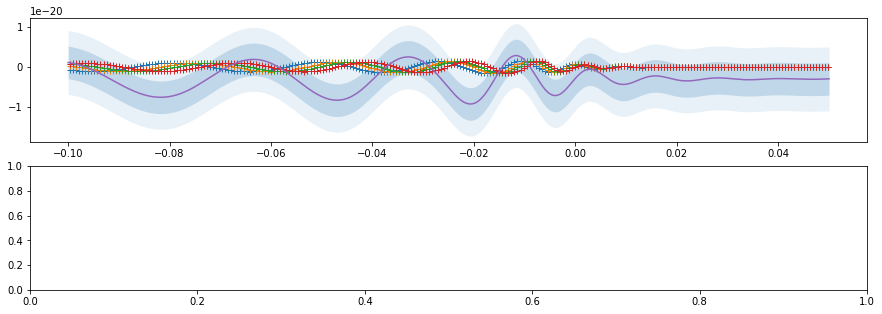

In [23]:
f, ax = plt.subplots(2,1, figsize=(15,5))
#test_point = 0

ax[0].plot(bbh_test_2[-1750:-1500, 0], bbh_test_2[-1750:-1500, -1], '+')  
ax[0].plot(bbh_test_2[-1500:-1250, 0], bbh_test_2[-1500:-1250, -1], '+')    
ax[0].plot(bbh_test_2[-1250:-1000, 0], bbh_test_2[-1250:-1000, -1], '+')
ax[0].plot(bbh_test_2[-1000:-750, 0], bbh_test_2[-1000:-750, -1], '+')

t = np.linspace(-0.1,0.05,1000)
new_point = np.zeros((1000,2))
new_point[:,1] = 0.1#89188# 0.17299376#0.07349688 + (0.0831211-0.07349688)/2
#new_point[:,2] = 0
new_point[:,0] = t
pred = gp.prediction(new_point)
ax[0].plot(t, pred[0])
#ax[0].set_ylim([-.5e-21, .5e-21])
#ax[0].set_xlim([-0.005, 0.005])
err =pred[1]
err2 = err*1.96
ax[0].fill_between(t, pred[0] - err, pred[0] + err , alpha = 0.2)
ax[0].fill_between(t, pred[0] - err2, pred[0] + err2 , alpha = 0.1)
##d = test.T[0][1] - test.T[0][0]
#ax[0].plot(test.T[0]+d, test.T[2])
#ax[1].plot(t, np.sqrt((test.T[2] - pred[0])**2))
#ax[1].plot(bbh_2.denormalise(bbh_2.test_targets[0:1000], "target")[:,0],
#           bbh_2.denormalise(bbh_2.test_labels[0:1000], "label"))
#ax[0].plot(bbh_test_2[-15900:-1,0], bbh_test_2[-250:-1,-1])
           #bbh_2.denormalise(bbh_2.test_labels[0:1000], "label"))


In [24]:
gp.test_predict()
gp.correlation()

0.26230385712619458

In [25]:
gp.rmse()

3.0527002942415545e-21

The expected improvement through the parameter space.

In [26]:
times = np.linspace(-0.1,0.05,100)
ratios = np.linspace(0.07, 0.175, 100)
data = np.zeros((100,100))
xv, yv = np.meshgrid(times, ratios, sparse=False, indexing='ij')
for i in xrange(100):
    for j in xrange(100):
        data[i][j] = gp.expected_improvement([xv[i,j], yv[i,j]])

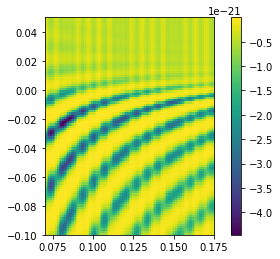

In [29]:
plt.imshow(data, extent=(0.07,0.175, -0.1, 0.05), interpolation="none", aspect=0.9, origin='lower')
plt.colorbar()

In [31]:
times = np.linspace(-0.1,0.05,100)
ratios = np.linspace(0.07, 0.175, 100)
pdata = np.zeros((100,100))
xv, yv = np.meshgrid(times, ratios, sparse=False, indexing='ij')
for i in xrange(100):
    for j in xrange(100):
        pdata[i][j] = gp.prediction([[xv[i,j], yv[i,j]]])[0]

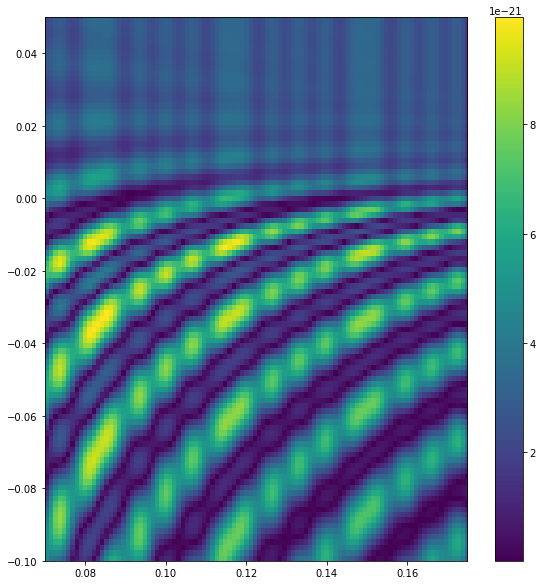

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(pdata), extent=(0.07,0.175, -0.1, 0.05), interpolation="none", aspect=0.9, origin='lower')
plt.colorbar()

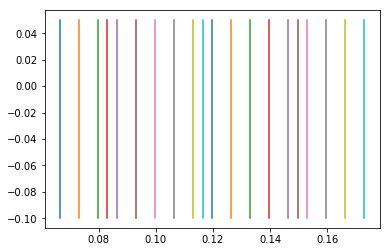

In [33]:
for i in range(len(bbh_data_2[:,0])/250):
    plt.plot(bbh_data_2[250*i:250*(i+1),1], bbh_data_2[250*i:250*(i+1),0])

(-0.1, 0.05)

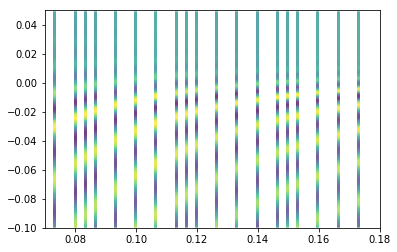

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

fig2 = plt.figure()
for i in range(len(bbh_data_2[:,0])/250):
    x = bbh_data_2[250*i:250*(i+1),1]
    y = bbh_data_2[250*i:250*(i+1),0]
    t = bbh_data_2[250*i:250*(i+1),-1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('viridis'),
                        )
    lc.set_array(t)
    lc.set_linewidth(3)

    plt.gca().add_collection(lc)
plt.xlim([0.07, 0.18])
plt.ylim([-0.10, 0.05])

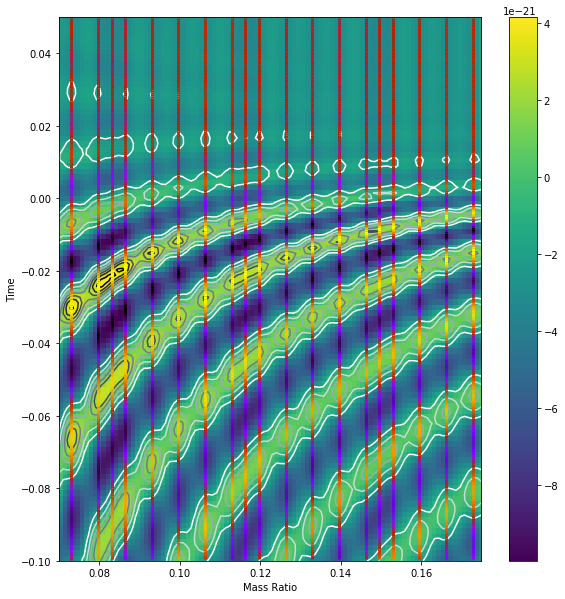

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

plt.figure(figsize=(10,10))
plt.imshow(pdata, extent=(0.07,0.175, -0.1, 0.05), 
           interpolation="none", aspect=0.9, origin='lower')
plt.colorbar()
plt.contour(data, extent=(0.07,0.175, -0.1, 0.05), cmap="bone")
for i in range(len(bbh_data_2[:,0])/250):
    x = bbh_data_2[250*i:250*(i+1),1]
    y = bbh_data_2[250*i:250*(i+1),0]
    t = bbh_data_2[250*i:250*(i+1),-1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('gnuplot'))
    lc.set_array(t)
    lc.set_linewidth(3)

    plt.gca().add_collection(lc)


plt.xlim([0.07, 0.175])
plt.ylim([-0.10, 0.05])
plt.xlabel('Mass Ratio')
plt.ylabel('Time')
#plt.savefig("time-mass.png")